Shawn (HyungJoon) Yoon

I worked with Annie Jung and Asli Mumtaz.

Question 0
0A: I followed the honor code on this problem set. (Answer Yes or No.)

Yes.


0B: How much time did you spend on this problem set?

8hrs

In [1]:
import linearmodels as lm
import pandas as pd
import seaborn as sns
import re 
%matplotlib inline

This notebook uses a number of important tools and techniques:
 1. [**Defining functions**](https://stackoverflow.com/questions/32409802/basic-explanation-of-python-functions) to encapsulate and reuse pieces of code that are used repeatedly.
 1. The regular expression module [**re**](https://docs.python.org/3/library/re.html); it's incredibly helpful to work with text patterns.
 1. The use of [**MultiIndices**](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) to describe data collecting observations at the  *(state, year)* level.
 1. The use of fixed effects to implement a [**diff in diff**](https://en.wikipedia.org/wiki/Difference_in_differences) estimator as an OLS.    
 Here we are dealing with what's called panel data: the observations correspond to a stable set of *entities* (here US state) being observed repeatedly over time.
 
Much of the data prep code is completed for you, but you should carefully look through the code to understand what each line is doing to convert the raw data into a dataset we can use for the analysis.

In [2]:
########Question 1: Data Prep########

########## 1A
## Import and reshape bankruptcies

# Import the data
Bankruptcies = pd.read_csv('Bankruptcies.csv', index_col=0) # insert file name

#simplify column names
def simplify_name(s):
    p = re.compile('Personal Bankruptcies (.*)  - Bankruptcies\n  - #')
    result = p.search(s)
    return result.group(1)

new_names = [simplify_name(name) for name in Bankruptcies.columns]
Bankruptcies.columns = new_names


# reshape dataframe using a year x state index
def reshape_dataframe(df, col_name=''):
    df = df.stack()
    df.index.names = ['Year', 'State']
    df.index
    return df.sort_index().to_frame(col_name)
        
Bankruptcies = reshape_dataframe(Bankruptcies, 'Bankruptcies')
Bankruptcies.head()

Bankruptcies
Year State                   
2006 Alabama            19546
     Alaska               579
     Arizona             7536
     Arkansas            9290
     California         37171

In [3]:
########## 1B
##Import and reshape income
#Import the data
Income = pd.read_csv('Income.csv') # fill in
Income['GeoName'] = Income['GeoName'].apply(lambda x: x.rstrip(' ').rstrip(' *'))

Income = Income.set_index('GeoName')

# in our context, when the year corresponds to a column, it's stored as a string
# print(Income.columns)
# # Index(['2006', '2007', '2008', '2009', '2010', '2011', '2012'], dtype='object')

# the function below makes sure the year is treated as a number when we transpose


def transpose_dataframe(df):
    
    df.columns = df.columns.astype(int) 
    return df.T

Income = reshape_dataframe(transpose_dataframe(Income), 'Income')

# The Year index is indeed treated as an Integer
# print(Income.index.levels[0])
# # Int64Index([2006, 2007, 2008, 2009, 2010, 2011, 2012], dtype='int64', name='Year')

Income.head()

Income
Year State             
2006 Alabama      31306
     Alaska       40881
     Arizona      34667
     Arkansas     29422
     California   42139

In [4]:
########## 1C
##Import and reshape Law_Restrictions
#Import data

Law_Restrictions = pd.read_csv('Bhutta_Law_Restrictions.csv', index_col=0) # fill in name
Law_Restrictions = reshape_dataframe(transpose_dataframe(Law_Restrictions), 'Law_Restrictions')# reshape dataframe like we did for Income
Law_Restrictions.head()

Law_Restrictions
Year State                       
2006 Alabama                    0
     Alaska                     0
     Arizona                    0
     Arkansas                   0
     California                 0

In [5]:
########## 1D
##Merge data
#Merge Bankruptcies with income to create DiD data
data = pd.concat([Bankruptcies, Income, Law_Restrictions], axis=1, sort=False) # fill in for ..., see defintion and examples of pandas.concat if having trouble
data = data.dropna()
data.head()

Bankruptcies   Income  Law_Restrictions
Year State                                              
2006 Alabama          19546.0  31306.0               0.0
     Alaska             579.0  40881.0               0.0
     Arizona           7536.0  34667.0               0.0
     Arkansas          9290.0  29422.0               0.0
     California       37171.0  42139.0               0.0

      Bankruptcies        Income
Year                            
2006  12358.479167  37034.375000
2007  16868.312500  38836.625000
2008  22059.645833  40181.000000
2009  29034.208333  38792.750000
2010  31602.062500  40020.062500
2011  26392.854167  42234.416667
2012  24274.270833  44039.958333

        Bankruptcies        Income  Law_Restrictions
count      48.000000     48.000000         48.000000
mean    26392.854167  42234.416667          0.354167
std     33561.234734   6718.127047          0.483321
min       942.000000  32190.000000          0.000000
25%      4817.500000  37724.750000          0.000000
50%     17461.500000  41185.000000          0.000000
75%     34529.500000  45203.000000          1.000000
max    207117.000000  63769.000000          1.000000


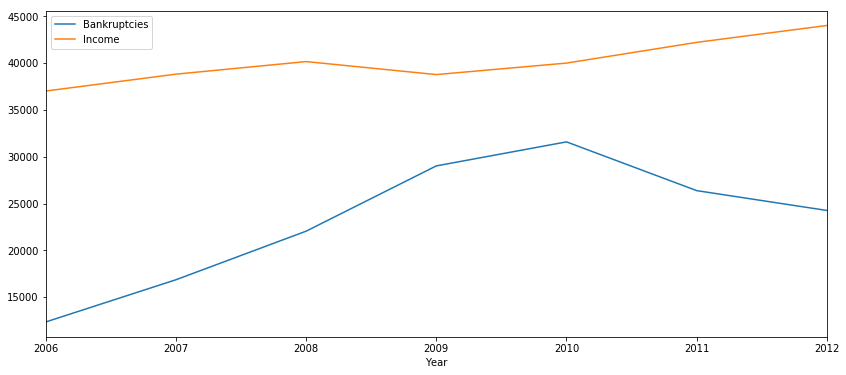

In [6]:
########## 1E
##Report summary statistics
#For Bankruptcies
trends_bkrpt_inc = data.groupby(level=0)[['Bankruptcies', 'Income']].mean()
print(trends_bkrpt_inc)
trends_bkrpt_inc.plot(figsize=(14,6))
print()
# add summary stats for 2011
print(data.loc[2011].describe())

      Law_Restrictions
Year                  
2006          0.229167
2007          0.229167
2008          0.250000
2009          0.291667
2010          0.312500
2011          0.354167
2012          0.354167


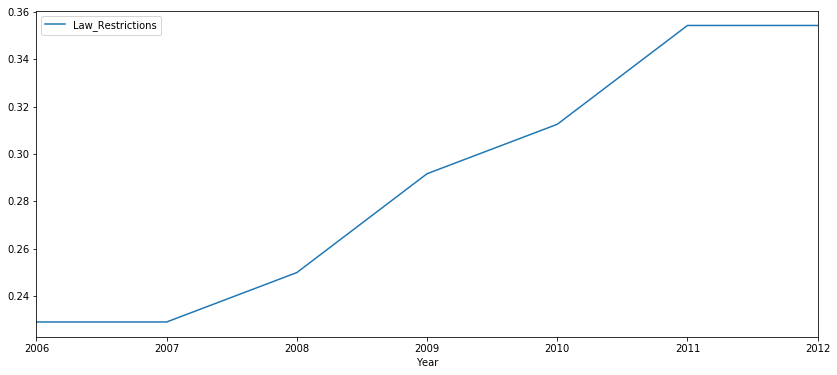

In [7]:
########Question 2: Analysis########

########## 2A
#Report how many states have laws restricting payday lending for each of the 
#years using a bar graph
#Use aggregate function to aggregate Law Restrictions by year

trends_restrict = data.groupby(level=0)[['Law_Restrictions']].mean() # fill in the function needed to get desired aggregation, see 1E if stuck
print(trends_restrict)
trends_restrict.plot(figsize=(14,6))

If we assume that there are 50 states in the data, then these are the number of states that has law restrictions for each year. 

In [8]:
trends_restrict*50

,Law_Restrictions
Year,
2006,11.458333
2007,11.458333
2008,12.500000
2009,14.583333
2010,15.625000
2011,17.708333
2012,17.708333


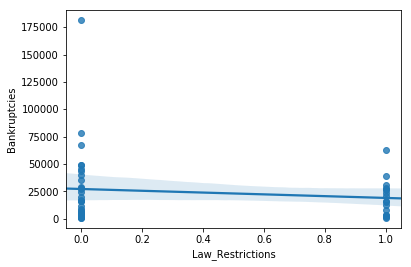

In [9]:
########## 2B
####Plot the relationship using a scatterplot between bankruptcy rates and payday
###lending restrictions for the latest year for which we have data.

sns.regplot(y="Bankruptcies", x="Law_Restrictions", data=data.loc[2012, :]) # fill in variables where there are currently ...

In [10]:
########## 2C 
#Estimate the regression coefficient for the relationship plotted in C
model = lm.OLS.from_formula("Bankruptcies ~ 1 + Law_Restrictions", data=data.loc[2012, :])
res = model.fit()
print(res.summary)

                            OLS Estimation Summary                            
Dep. Variable:           Bankruptcies   R-squared:                      0.0174
Estimator:                        OLS   Adj. R-squared:                -0.0040
No. Observations:                  48   F-statistic:                    1.2518
Date:                Thu, Dec 12 2019   P-value (F-stat)                0.2632
Time:                        05:38:58   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
Intercept         2.716e+04     6208.5     4.3753     0.0000     1.5e+04   3.933e+04
Law_Restrictions    -8158.2 

The regression coefficient is -8158.2

#### 2D

Would you interpret that correlation as evidence that payday lending laws cause bankruptcies to
increase or decrease? Why or why not? (Hint: Are you concerned about omitted variable bias? What
omitted variables might be relevant?)


It would be a bold statement to say that law restrictions decrease bankruptcies, because there are too many unidentified variables at this point. So, we can't conclude anything from this. 

For example, the states that had law restrictions might have lower bankruptcies rate from the start, and the law restriction may have no effects on bankruptcies rate. 

In [43]:
########## 2E
#Perform a diff-in-diff analysis without the income control and report the estimates

# the typical panel data convention is to have the entity correspond to the first index, 
# and the time correspond to the second index
# the *linearmodel* package needs us to follow that convention

if data.index.names[0] == 'Year':
    data = data.swaplevel(i=0, j=1)
    data = data.sort_index()
    
print(data.head(), '\n\n')


reg_formula = 'Bankruptcies ~ 0 + EntityEffects + TimeEffects + Law_Restrictions' # what's missing?

model = lm.PanelOLS.from_formula(reg_formula, data=data)
res = model.fit()
print(res.summary)


              Bankruptcies   Income  Law_Restrictions
State   Year                                         
Alabama 2006       19546.0  31306.0               0.0
        2007       23572.0  32573.0               0.0
        2008       29018.0  33377.0               0.0
        2009       34180.0  32631.0               0.0
        2010       33403.0  33844.0               0.0 


                          PanelOLS Estimation Summary                           
Dep. Variable:           Bankruptcies   R-squared:                        0.0015
Estimator:                   PanelOLS   R-squared (Between):             -0.0269
No. Observations:                 336   R-squared (Within):              -0.0064
Date:                Wed, Dec 11 2019   R-squared (Overall):             -0.0245
Time:                        13:36:22   Log-likelihood                   -3604.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:

In [44]:
########## 2F
#Now add the control variable. How do the results change?

reg_formula_income = 'Bankruptcies ~ 0 + EntityEffects + TimeEffects + Income + Law_Restrictions'

model = lm.PanelOLS.from_formula(reg_formula_income, data=data)
res = model.fit()
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:           Bankruptcies   R-squared:                        0.0501
Estimator:                   PanelOLS   R-squared (Between):             -9.0779
No. Observations:                 336   R-squared (Within):              -0.2672
Date:                Wed, Dec 11 2019   R-squared (Overall):             -8.0534
Time:                        13:37:05   Log-likelihood                   -3596.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7.3798
Entities:                          53   P-value                           0.0008
Avg Obs:                       6.3396   Distribution:                   F(2,280)
Min Obs:                       0.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             7.3798
                            

Yes. The coefficient for law_restirctions change by around 1334. This is due to the omitted variable biasness.

The reason is that we identified the income variable. Before we identified the income variable, the law restriction coefficient was holding the income coefficient times the coefficient of income on law restriction.  

### 2G) Using your results from the regression in 2F, interpret the magnitude and statistical significance of the relationship between income and bankruptcies, as well as the relationship between payday lending restrictions and bankruptcies.

The coefficient for the income variable is -2.0648. This means that when income increases by 1, then the bankruptcies drop by 2.0648. The p-value of the income coefficient is 0.0002 which is less than 0.05. It rejects the null hypothesis that the coefficient is zero. So, income coefficient is statistically significant. 

The coefficient for the law restrictions dummy variable is -4018.8. This means that when there is a law restriction, then the bankruptcies drop by 4018.8. The p-value of the law restrictions coefficient is 0.3210 which is bigger than 0.05. So, this tells that the law restriction coefficient is not statistically significant. It doesn't reject the null hypothesis, but we can leniently rely on the number we got for the law restriction coefficient. 

### 2H) Would you still be concerned with omitted variables bias now?

Yes. There could be more variables in the unobservables that has high correlation with law restrictions 

One example would be unemployment rate. Unemployment rate does not have direct relationship with law restriction, but it is indirectly related, and therefore it might have high correlation between the two. 

### 2I) As we covered in class, the CFPB finalized a payday lending regulation in October 2017 (link to press release). Define a nudge. Give a few bullet points explaining the key parts of the rule, and clarify the rationale behind the regulatory strategy used, incorporating both your empirical results from this problem set and our class discussion.

Is this data on bankruptcies the number of bankruptcies or the amount of money people default on?

The nudge is something that helps consumers make right and better decisions without hurting or changing other customer's choice and quantity. 

The regulation does not block payday loans because people who are in need of the loans will still have access to them. However, they try to discourage people from taking the payday loans without fully understanding the consequences and the interest rate that they have to pay back by cracking down business models and practices. Therefore, they are basically helping consumers, who are already vulnerable, from running into traps that organizations have set up.